Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

       Other       1.00      1.00      1.00      5988
        WBFM       1.00      1.00      1.00      6045
      AM-DSB       1.00      1.00      1.00      5967

    accuracy                           1.00     18000
   macro avg       1.00      1.00      1.00     18000
weighted avg       1.00      1.00      1.00     18000



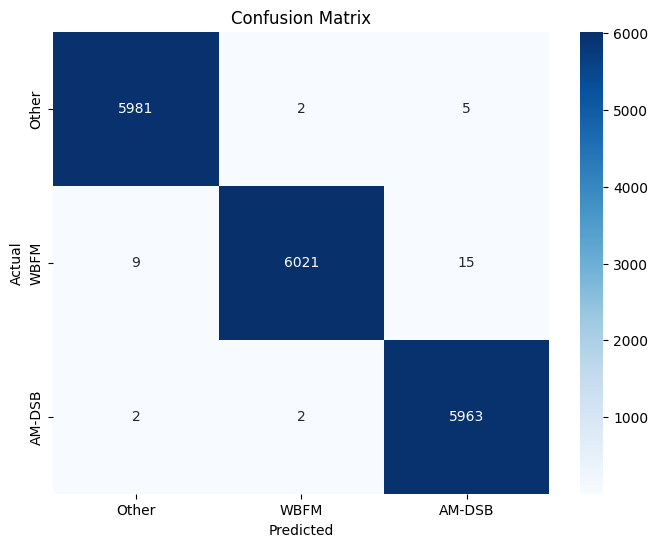

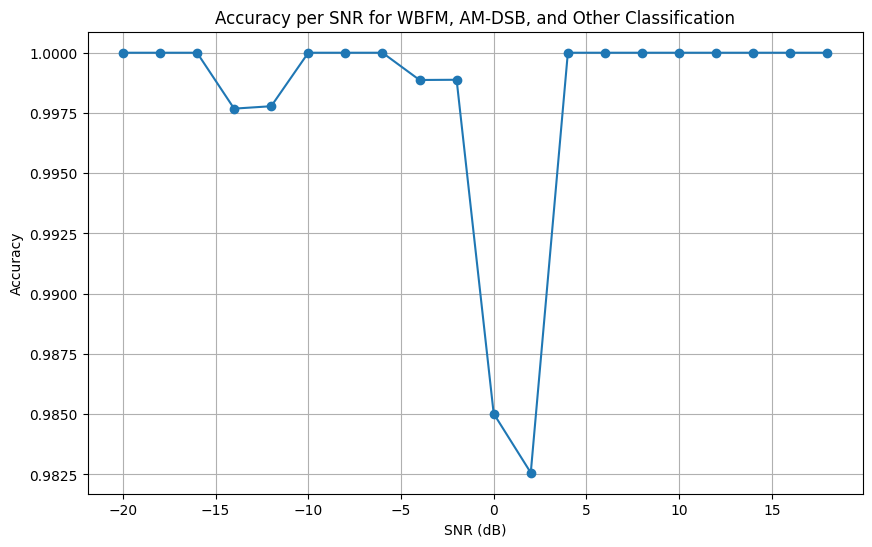

Model Performance for WBFM, AM-DSB, and Other Classification
              precision    recall  f1-score   support

       Other       1.00      1.00      1.00      5988
        WBFM       1.00      1.00      1.00      6045
      AM-DSB       1.00      1.00      1.00      5967

    accuracy                           1.00     18000
   macro avg       1.00      1.00      1.00     18000
weighted avg       1.00      1.00      1.00     18000



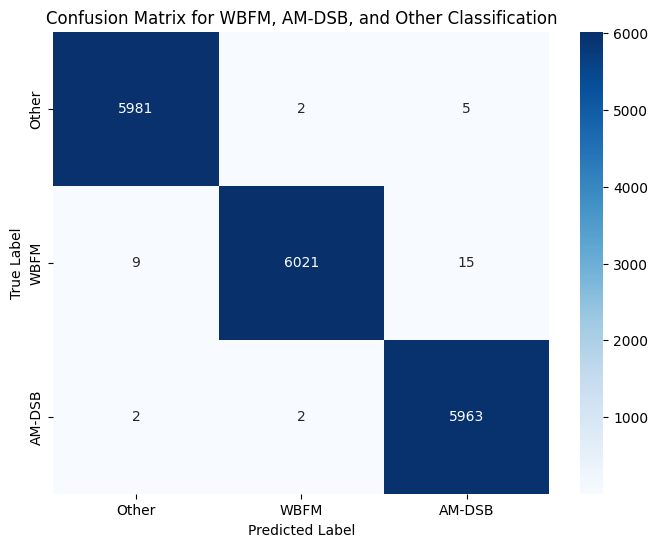

In [1]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from ml_wireless_classification.base.SignalUtils import extract_comprehensive_features
import matplotlib.pyplot as plt
import seaborn as sns

# Define selected features
SELECTED_FEATURES = [
    "Spectral Peak Ratio (Magnitude)",  # 0
    "Frequency Domain Entropy with High-Frequency Emphasis",  # 2
    "Wavelet Entropy Multiple Scales (Quadratic)"  # 3
]

# WBFM Demodulator
def wbfm_demodulate(iq_signal, sample_rate=1e6, deviation=75e3):
    phase = np.unwrap(np.angle(iq_signal))
    instantaneous_freq = np.diff(phase) / (2 * np.pi) * sample_rate
    demodulated = instantaneous_freq / deviation
    return np.pad(demodulated, (1, 0), mode="constant", constant_values=0)

# AM-DSB Demodulator
def am_dsb_demodulate(iq_signal):
    envelope = np.abs(iq_signal)
    demodulated = envelope - np.mean(envelope)
    return demodulated

# Filter modulations
def filter_modulations(data):
    """
    Retain three distinct labels: WBFM, AM-DSB, and Other.
    """
    filtered_data = {}
    for key, signals in data.items():
        mod_type, snr = key
        if mod_type == "WBFM":
            filtered_data[(mod_type, snr)] = signals
        elif mod_type == "AM-DSB":
            filtered_data[(mod_type, snr)] = signals
        else:
            filtered_data[("Other", snr)] = signals  # Label all other modulations as "Other"
    return filtered_data

# Feature extraction
def extract_features_with_snr(data, selected_features, sample_rate=1e6):
    """
    Extract features for WBFM, AM-DSB, and Other.
    """
    features, labels, snr_values = [], [], []

    for (mod_type, snr), signals in data.items():
        for signal in signals:
            iq_signal = signal[0] + 1j * signal[1]

            # Apply appropriate demodulator
            if mod_type == "WBFM":
                demodulated_signal = wbfm_demodulate(iq_signal, sample_rate)
            elif mod_type == "AM-DSB":
                demodulated_signal = am_dsb_demodulate(iq_signal)
            else:
                demodulated_signal = iq_signal.real

            # Extract features
            feature_dict = extract_comprehensive_features(demodulated_signal, selected_features)
            feature_dict["SNR"] = snr

            # Gather extracted features
            extracted = [feature_dict.get(f, 0) for f in selected_features] + [snr]
            features.append(extracted)

            # Assign labels: 0 = Other, 1 = WBFM, 2 = AM-DSB
            if mod_type == "WBFM":
                labels.append(1)
            elif mod_type == "AM-DSB":
                labels.append(2)
            else:
                labels.append(0)

            snr_values.append(snr)

    return np.array(features), np.array(labels), np.array(snr_values)

# Load dataset
with open("../RML2016.10a_dict.pkl", "rb") as f:
    data = pickle.load(f, encoding="latin1")

# Filter data for WBFM, AM-DSB, and Other
filtered_data = filter_modulations(data)

# Extract features and labels
features, labels, snr_values = extract_features_with_snr(filtered_data, SELECTED_FEATURES)

# Split data into training and testing sets, including SNR values
X_train, X_test, y_train, y_test, snr_train, snr_test = train_test_split(
    features, labels, snr_values, test_size=0.3, random_state=42
)


from ml_wireless_classification.base.TestingUtils import convert_and_clean_data, ensure_2d

# Train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
target_names = ["Other", "WBFM", "AM-DSB"]
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Convert y_test and y_pred to NumPy arrays for indexing
y_test = np.array(y_test)
y_pred = np.array(y_pred)

# Compute accuracy per SNR
snr_accuracy = {}
unique_snr_values = np.unique(snr_test)

for snr in unique_snr_values:
    indices = np.where(snr_test == snr)
    accuracy = accuracy_score(y_test[indices], y_pred[indices])
    snr_accuracy[snr] = accuracy

# Plotting accuracy per SNR
plt.figure(figsize=(10, 6))
plt.plot(list(snr_accuracy.keys()), list(snr_accuracy.values()), marker='o')
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.title("Accuracy per SNR for WBFM, AM-DSB, and Other Classification")
plt.grid(True)
plt.show()

# Display the classification report for overall performance
target_names = ["Other", "WBFM", "AM-DSB"]
print("Model Performance for WBFM, AM-DSB, and Other Classification")
print(classification_report(y_test, y_pred, target_names=target_names))

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for WBFM, AM-DSB, and Other Classification")
plt.show()


Overall Accuracy: 0.49
Classification Report:
              precision    recall  f1-score   support

        8PSK       0.20      0.21      0.21      5986
      AM-DSB       0.96      0.98      0.97      6031
      AM-SSB       0.61      0.66      0.63      5969
        BPSK       0.36      0.32      0.34      6054
       CPFSK       0.29      0.34      0.31      6054
        GFSK       0.55      0.55      0.55      5947
        PAM4       0.45      0.40      0.43      6026
       QAM16       0.30      0.29      0.30      5897
       QAM64       0.42      0.43      0.42      5965
        QPSK       0.19      0.17      0.18      6123
        WBFM       1.00      1.00      1.00      5948

    accuracy                           0.49     66000
   macro avg       0.48      0.49      0.48     66000
weighted avg       0.48      0.49      0.48     66000



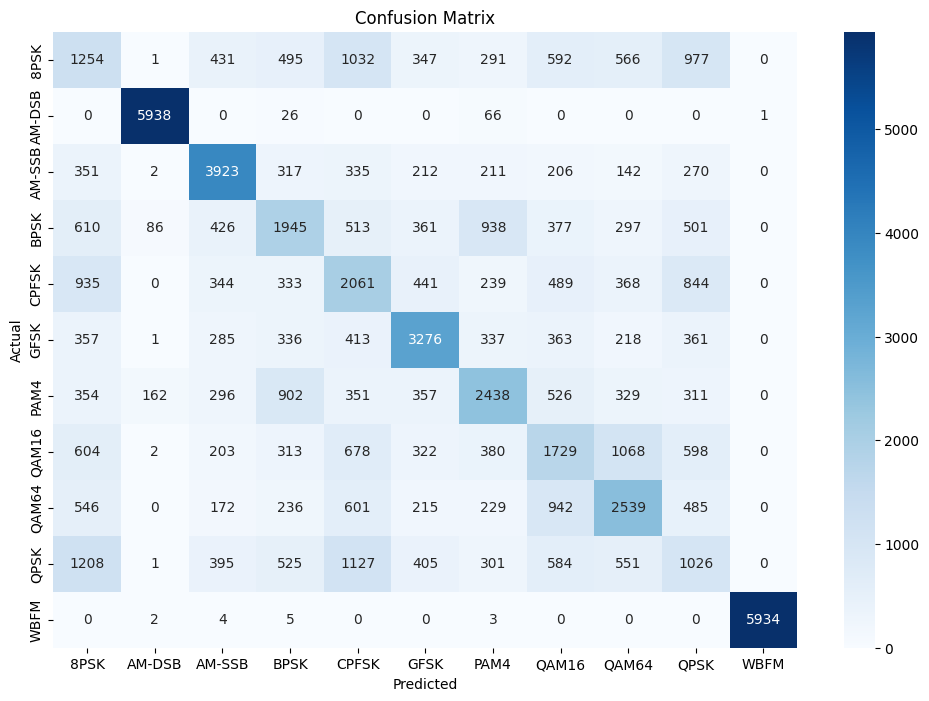

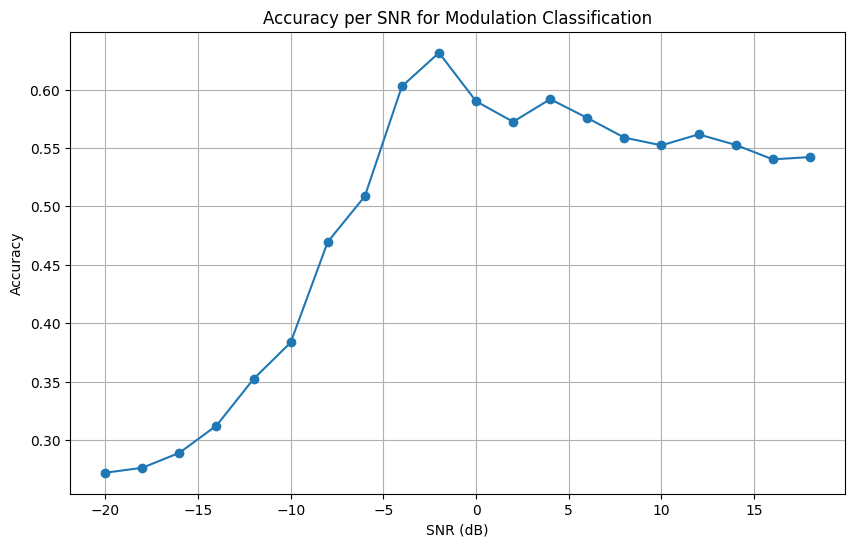

In [2]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from ml_wireless_classification.base.SignalUtils import extract_comprehensive_features
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Define selected features
SELECTED_FEATURES = [
    "Spectral Peak Ratio (Magnitude)",  # 0
    "Frequency Domain Entropy with High-Frequency Emphasis",  # 2
    "Wavelet Entropy Multiple Scales (Quadratic)"  # 3
]

# WBFM Demodulator
def wbfm_demodulate(iq_signal, sample_rate=1e6, deviation=75e3):
    phase = np.unwrap(np.angle(iq_signal))
    instantaneous_freq = np.diff(phase) / (2 * np.pi) * sample_rate
    demodulated = instantaneous_freq / deviation
    return np.pad(demodulated, (1, 0), mode="constant", constant_values=0)

# AM-DSB Demodulator
def am_dsb_demodulate(iq_signal):
    envelope = np.abs(iq_signal)
    demodulated = envelope - np.mean(envelope)
    return demodulated

# Feature extraction
def extract_features_with_snr(data, selected_features, sample_rate=1e6):
    """
    Extract features for all modulation types.
    """
    features, labels, snr_values = [], [], []

    for (mod_type, snr), signals in data.items():
        for signal in signals:
            iq_signal = signal[0] + 1j * signal[1]

            # Apply appropriate demodulator if necessary
            if mod_type == "WBFM":
                demodulated_signal = wbfm_demodulate(iq_signal, sample_rate)
            elif mod_type == "AM-DSB":
                demodulated_signal = am_dsb_demodulate(iq_signal)
            else:
                demodulated_signal = iq_signal.real

            # Extract features
            feature_dict = extract_comprehensive_features(demodulated_signal, selected_features)
            feature_dict["SNR"] = snr

            # Gather extracted features
            extracted = [feature_dict.get(f, 0) for f in selected_features] + [snr]
            features.append(extracted)

            # Assign label as the modulation type
            labels.append(mod_type)
            snr_values.append(snr)

    return np.array(features), np.array(labels), np.array(snr_values)

# Load dataset
with open("../RML2016.10a_dict.pkl", "rb") as f:
    data = pickle.load(f, encoding="latin1")

# Extract features and labels for all modulations
features, labels, snr_values = extract_features_with_snr(data, SELECTED_FEATURES)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test, snr_train, snr_test = train_test_split(
    features, encoded_labels, snr_values, test_size=0.3, random_state=42
)

# Train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.2f}")

# Classification report
target_names = label_encoder.classes_
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Compute accuracy per SNR
snr_accuracy = {}
unique_snr_values = np.unique(snr_test)

for snr in unique_snr_values:
    indices = np.where(snr_test == snr)
    accuracy = accuracy_score(y_test[indices], y_pred[indices])
    snr_accuracy[snr] = accuracy

# Plotting accuracy per SNR
plt.figure(figsize=(10, 6))
plt.plot(list(snr_accuracy.keys()), list(snr_accuracy.values()), marker='o')
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.title("Accuracy per SNR for Modulation Classification")
plt.grid(True)
plt.show()
